In [38]:
import json
import os
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import scipy.optimize as opt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from copy import deepcopy
from utils import boxplot_significance, extract_data, violinplot_significance, splitedviolinplot_significance # per importare dento al codice (utils.py) le def (in questo caso boxplot_significance e extract_data)


In [39]:
# qui ogni volta va chiamata la cartella corretta del file di Log

json_files = [pos_json for pos_json in os.listdir("Log") if pos_json.endswith('.json')]
data = []
for index, js in enumerate(json_files):
    with open(os.path.join('./Log/', js)) as json_file:
        json_text = json.load(json_file)
        data.append(json_text)

print(json_files)
print(len(json_files))

['logfile_20250411_114956.json', 'logfile_20250403_122328.json', 'logfile_20250403_102854.json', 'logfile_20250328_111350.json', 'logfile_20250402_154441.json', 'logfile_20250321_122554.json', 'logfile_20250319_094340.json', 'logfile_20250327_161307.json', 'logfile_20250404_175224.json', 'logfile_20250319_120923.json', 'logfile_20250402_101522.json', 'logfile_20250327_103947.json', 'logfile_20250411_170105.json', 'logfile_20250320_113159.json', 'logfile_20250416_093830.json', 'logfile_20250402_172451.json', 'logfile_20250321_155138.json', 'logfile_20250404_155009.json', 'logfile_20250411_152611.json', 'logfile_20250319_151412.json', 'logfile_20250320_154557.json', 'logfile_20250320_132144.json', 'logfile_20250410_152658.json', 'logfile_20250327_175815.json', 'logfile_20250328_155903.json', 'logfile_20250410_172416.json', 'logfile_20250320_182801.json', 'logfile_20250327_123422.json', 'logfile_20250416_174530.json', 'logfile_20250326_133256.json', 'logfile_20250326_103619.json', 'logfil

In [40]:
import pandas as pd

# Legge il file Excel (assicurati che il file sia nella stessa directory dello script)
questionnaire_df = pd.read_excel("Questionnaires_scores.xlsx")

points_df = pd.read_excel("block_and_half_sums.xlsx")

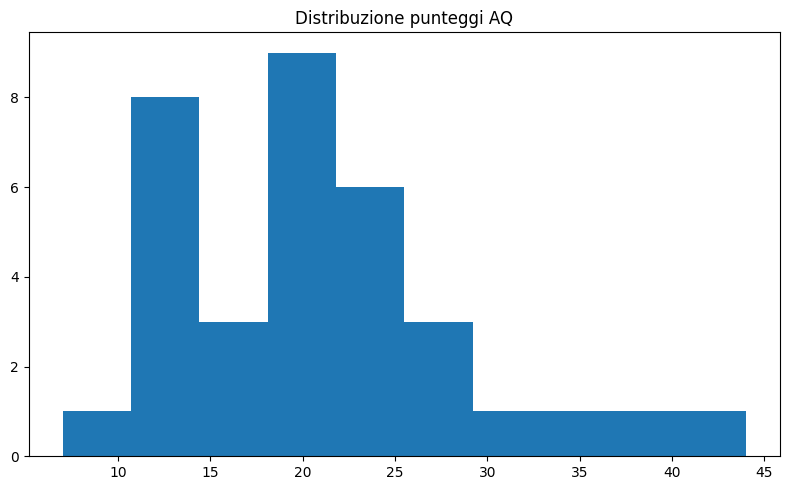

Number of participants with AQ score above 32: 3


In [41]:
import pandas as pd
import matplotlib.pyplot as plt

aq_scores = questionnaire_df["AQ_score"]

plt.figure(figsize=(8, 5))
plt.hist(aq_scores)
plt.title('Distribuzione punteggi AQ')
plt.tight_layout()
plt.show()


# Count how many scores are above 32
count_above_32 = (aq_scores > 32).sum()

print(f"Number of participants with AQ score above 32: {count_above_32}")


Basic statistics of the AQ scores

In [42]:
import pandas as pd
from statistics import mode

aq_series = pd.Series(aq_scores)

# Basic stats
print("Mean:", aq_series.mean())
print("Median:", aq_series.median())
print("Mode:", mode(aq_scores))  # Using mode from statistics
print("Min:", aq_series.min())
print("Max:", aq_series.max())
print("Standard Deviation:", aq_series.std())


Mean: 20.735294117647058
Median: 20.5
Mode: 11
Min: 7
Max: 44
Standard Deviation: 7.955591986160891


In [43]:
# Convert to DataFrame
df = pd.DataFrame({"AQ_Score": aq_scores})

# Use qcut to split into 3 equal-sized groups (tertiles)
df["Category"] = pd.qcut(df["AQ_Score"], q=3, labels=["Low AQ", "Medium AQ", "High AQ"])

# Display the category counts
print(df["Category"].value_counts())

# Optional: view the cut points
cut_points = pd.qcut(df["AQ_Score"], q=3, retbins=True)[1]
print("Tertile cut points:", cut_points)


Category
Low AQ       12
Medium AQ    12
High AQ      10
Name: count, dtype: int64
Tertile cut points: [ 7. 18. 22. 44.]


In [44]:
def count_box_opened(trial_events):
    hist = []
    for event in trial_events:
        if event["trialEvent"].startswith("Opened"):
            hist.append(event["room"])

    count = Counter({"North": 0, "South": 0, "East": 0, "West": 0})
    count.update(hist)
    return hist, count

def count_box_opened_over_trials(trials):
    counts = {room: [] for room in ["North", "South", "East", "West"]}
    hists = []
    for trial in trials:
        hist, count = count_box_opened(trial["events"])
        for room in ["North", "South", "East", "West"]:
            counts[room].append(count[room])
        hists.append(hist)
    return counts, hists


In [45]:
import pandas as pd
from copy import deepcopy
from statistics import mode

# Importa i questionari
questionnaire_df = pd.read_excel("Questionnaires_scores.xlsx")
# Importa il file con i TotalPoints
points_df = pd.read_excel("block_and_half_sums.xlsx")

# 2. Ordina i dati in base al nickname
names = [log["user"]["nickname"] for log in data]
new_order = [names.index(name) for name in sorted(names)]
new_data = [data[idx] for idx in new_order]
data = deepcopy(new_data)

# 3. Ricostruisci user_data in ordine
user_data = {}
for idx, log in enumerate(data):
    nickname = log["user"]["nickname"]
    _, hists = count_box_opened_over_trials(log["trials"])
    
    number_of_correct_choices = []
    percent_correct_choices_over_actions = []
    number_correct_choices_over_first_10 = []
    for trial_number, hist in enumerate(hists[4:]):
        if (trial_number // 10) % 2 == 0:
            corrects = hist.count("North") + hist.count("South")
        else:
            corrects = hist.count("West") + hist.count("East")
        number_of_correct_choices.append(corrects)
        percent_correct_choices_over_actions.append(corrects / len(hist))
        
        if (trial_number // 10) % 2 == 0:
            corrects_first10 = hist[:10].count("North") + hist[:10].count("South")
        else:
            corrects_first10 = hist[:10].count("West") + hist[:10].count("East")
        
        corrects_first10 /= min(len(hist), 10)
        number_correct_choices_over_first_10.append(corrects_first10)
    
    user_data[idx] = {
        "nickname": nickname,
        "number_of_correct_choices": number_of_correct_choices,
        "percent_correct_choices_over_actions": percent_correct_choices_over_actions,
        "number_correct_choices_over_first_10": number_correct_choices_over_first_10,
    }

# 4. Crea la prima tabella df
table_data = []
for subject_idx, subject_info in user_data.items():
    subject_name = f"Soggetto {subject_idx + 1}"
    nickname = subject_info["nickname"]
    correct_choices = subject_info["number_of_correct_choices"]

    block_values = [sum(correct_choices[i*10:(i+1)*10]) for i in range(6)]
    total = sum(block_values)

    row = {
        "Soggetto": subject_name,
        "Nickname": nickname,
        **{f"Blocco {i+1}": block_values[i] for i in range(6)},
        "Totale": total
    }
    table_data.append(row)

df = pd.DataFrame(table_data)

# Rimuovi le colonne Blocco 1-6
df.drop(columns=[f"Blocco {i+1}" for i in range(6)], inplace=True)

# Rinomina Totale
df.rename(columns={"Totale": "totale_right_choices"}, inplace=True)

# AQ_score, STAI_score e Gamers_score
questionnaire_df["Name"] = questionnaire_df["Name"].str.strip()
df["Nickname"] = df["Nickname"].str.strip()

# Merge multiplo
df = df.merge(
    questionnaire_df[["Name", "AQ_score", "STAI_S","STAI_T", "Gamers_score"]],
    how="left",
    left_on="Nickname",
    right_on="Name"
)
df.drop(columns=["Name"], inplace=True)

# --- Aggiungi la colonna TotalPoints dal file block_and_half_sums.xlsx ---
points_df["Subject"] = points_df["Subject"].str.strip()
df = df.merge(points_df[["Subject", "TotalPoints"]], how="left", left_on="Nickname", right_on="Subject")
df.drop(columns=["Subject"], inplace=True)

# --- Aggiungi la colonna average_second_first_difference dal file block_and_half_sums.xlsx ---
points_df["Subject"] = points_df["Subject"].str.strip()
df = df.merge(points_df[["Subject", "average_second_first_difference"]], how="left", left_on="Nickname", right_on="Subject")
df.drop(columns=["Subject"], inplace=True)

# --- Aggiungi la colonna sum_second_first_difference dal file block_and_half_sums.xlsx ---
points_df["Subject"] = points_df["Subject"].str.strip()
df = df.merge(points_df[["Subject", "sum_second_first_difference"]], how="left", left_on="Nickname", right_on="Subject")
df.drop(columns=["Subject"], inplace=True)

# --- Calcolo della media delle scelte corrette nei primi 10 tentativi ---
average_correct_10_actions = []
for subject_idx, subject_info in user_data.items():
    correct_choices_10 = subject_info["number_correct_choices_over_first_10"]
    block_means_10 = [sum(correct_choices_10[i*10:(i+1)*10]) / 10 for i in range(6)]
    avg_of_block_means_10 = sum(block_means_10) / len(block_means_10)
    average_correct_10_actions.append(avg_of_block_means_10)

df["totale_percent_choices_over_10_actions"] = average_correct_10_actions

# --- Calcolo della media percentuale di scelte corrette ---
average_correct_choices_actions = []
for subject_idx, subject_info in user_data.items():
    correct_choices_actions = subject_info["percent_correct_choices_over_actions"]
    block_means_percent = [sum(correct_choices_actions[i*10:(i+1)*10]) / 10 for i in range(6)]
    avg_of_block_means_percent = sum(block_means_percent) / len(block_means_percent)
    average_correct_choices_actions.append(avg_of_block_means_percent)

df["percent_correct_choices_over_actions"] = average_correct_choices_actions

# --- Classifica AQ_score in 3 gruppi (terzili) e assegna valori numerici ---
# COSì FACENDO MI STO PRENDENDO TUTTI I SCORE AQ e sto dividendo i score in tre parti uguali,
# così mi ricavo una fascia basso AQ, medio AQ, alto AQ.
# nella colonna AQ_level avrò 1 per indicare livello super low AQ, 2 low AQ, 3 high AQ, 4 super high
df["AQ_level"] = pd.qcut(df["AQ_score"], q=4, labels=[1, 2, 3, 4])
df["AQ_level"] = df["AQ_level"].astype("int")

# 6. Visualizza la tabella finale aggiornata
print(df)


       Soggetto Nickname  totale_right_choices  AQ_score  STAI_S  STAI_T  \
0    Soggetto 1   Annnag                   483        26      42      44   
1    Soggetto 2   Annsch                   540        11      36      42   
2    Soggetto 3   Ashpas                   495        23      60      56   
3    Soggetto 4   Carcri                   559        22      39      58   
4    Soggetto 5   Danmil                   390        11      37      41   
5    Soggetto 6   Danray                   466        21      45      28   
6    Soggetto 7   Felmue                   561        19      38      37   
7    Soggetto 8   Finkul                   545        44      38      58   
8    Soggetto 9   Gabtan                   533        21      26      32   
9   Soggetto 10   Giafer                   494        27      53      52   
10  Soggetto 11   Haasaa                   551        18      29      46   
11  Soggetto 12   Hamfra                   399        17      23      29   
12  Soggetto

<span style="color:red">DA QUI IN POI FACCIO CORRELAZIONI CON AQ</span>


- CORRELAZIONE **AQ E TOTALE SCELTE CORRETTE**

In [46]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["AQ_score", "totale_right_choices"])
correlation, p_value = spearmanr(df_clean["AQ_score"], df_clean["totale_right_choices"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")


Correlazione di spearmanr: -0.06840833140709958
p-value: 0.7006697571750691
La correlazione NON è statisticamente significativa.


- CORRELAZIONE TRA **AQ LEVEL E TOTALE SCELTE CORRETTE**

In [47]:
# faccio SPEARMAN perchè la variabile AQ_level non è continua, ma è ORDINALE
from scipy.stats import spearmanr

rho, p_value = spearmanr(df_clean["AQ_level"], df_clean["totale_right_choices"])

print(f"Spearman rho: {rho}")
print(f"p-value: {p_value}")


if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")


Spearman rho: -0.07172995461053383
p-value: 0.686853024771505
La correlazione NON è statisticamente significativa.


- CORRELAZIONE **AQ E TOTALE SCELTE CORRETTE ENTRO LE PRIME 10 AZIONI**

In [48]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["AQ_score", "totale_percent_choices_over_10_actions"])
correlation, p_value = spearmanr(df_clean["AQ_score"], df_clean["totale_percent_choices_over_10_actions"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")


Correlazione di spearmanr: -0.07275814001286704
p-value: 0.6825960162481304
La correlazione NON è statisticamente significativa.


- CORRELAZIONE TRA **AQ LEVEL E TOTALE SCELTE CORRETTE ENTRO LE PRIME 10 AZIONI**

In [49]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(df_clean["AQ_level"], df_clean["totale_percent_choices_over_10_actions"])

print(f"Spearman rho: {rho}")
print(f"p-value: {p_value}")


if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Spearman rho: -0.05995849311030888
p-value: 0.7362365761614815
La correlazione NON è statisticamente significativa.


- CORRELAZIONE **AQ E TOTALE SCELTE CORRETTE / AZIONI**


In [50]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["AQ_score", "percent_correct_choices_over_actions"])
correlation, p_value = spearmanr(df_clean["AQ_score"], df_clean["percent_correct_choices_over_actions"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: -0.09496851959574226
p-value: 0.5931657884006529
La correlazione NON è statisticamente significativa.


- CORRELAZIONE TRA **AQ LEVEL E TOTALE SCELTE CORRETTE / AZIONI**

In [51]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(df_clean["AQ_level"], df_clean["percent_correct_choices_over_actions"])

print(f"Spearman rho: {rho}")
print(f"p-value: {p_value}")


if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")


Spearman rho: -0.039761948062625896
p-value: 0.8233285271613094
La correlazione NON è statisticamente significativa.


- CORRELAZIONE **AQ E TOTALE PUNTI**


In [52]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["AQ_score", "TotalPoints"])
correlation, p_value = spearmanr(df_clean["AQ_score"], df_clean["TotalPoints"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: -0.1096733226299217
p-value: 0.536939979045948
La correlazione NON è statisticamente significativa.


In [53]:
from scipy.stats import spearmanr


df_clean = df.dropna(subset=["AQ_score", "TotalPoints"])
correlation, p_value = spearmanr(df_clean["AQ_score"], df_clean["TotalPoints"])

print(f"Correlazione di Spearman: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")


Correlazione di Spearman: -0.1096733226299217
p-value: 0.536939979045948
La correlazione NON è statisticamente significativa.


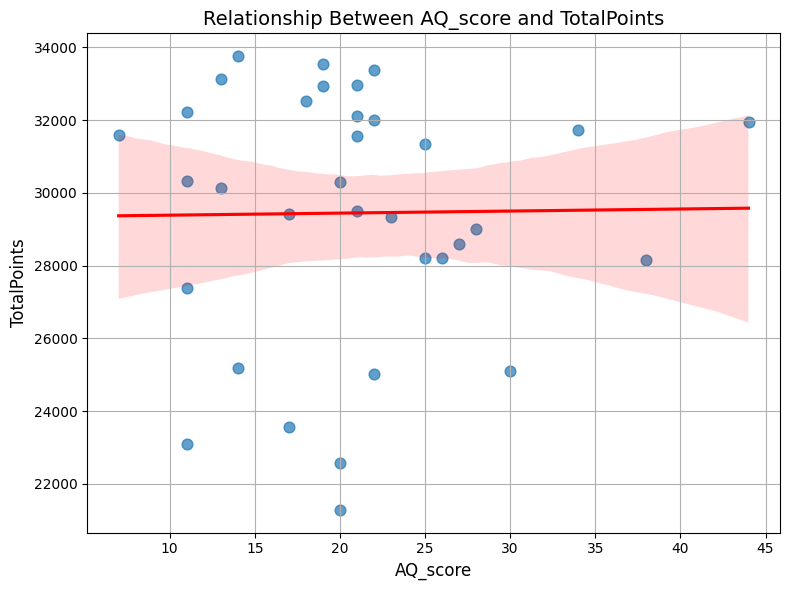

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pulisci i dati
df_clean = df.dropna(subset=["AQ_score", "TotalPoints"])

# Crea il grafico scatter con linea di regressione
plt.figure(figsize=(8, 6))
sns.regplot(
    x="AQ_score",
    y="TotalPoints",
    data=df_clean,
    ci=95,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Aggiungi titoli e label
plt.title("Relationship Between AQ_score and TotalPoints", fontsize=14)
plt.xlabel("AQ_score", fontsize=12)
plt.ylabel("TotalPoints", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


- CORRELAZIONE **AQ LEVEL E TOTALE PUNTI**


In [55]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(df_clean["AQ_level"], df_clean["TotalPoints"])

print(f"Spearman rho: {rho}")
print(f"p-value: {p_value}")


if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Spearman rho: -0.1085564296312961
p-value: 0.5411193156684313
La correlazione NON è statisticamente significativa.


- CORRELAZIONE TRA **AQ E DIFFERENZE, MEDIATE PER SOGGETTO, TRA SECONDA E PRIMA METà**

voglio vedere se facendo seconda - prima metà di ogni blocco e poi le somme tra queste per ogni soggetto c'è una correlazione - con aspetativa di trovare valori più bassi di diff tra prima e seconda metà con chi ha tratti autistici più alti

In [56]:
from scipy.stats import spearmanr

df_clean = df.dropna(subset=["AQ_score", "average_second_first_difference"])

correlation, p_value = spearmanr(df_clean["AQ_score"], df_clean["average_second_first_difference"])

print(f"Correlazione di Spearman: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di Spearman: -0.30068258704264844
p-value: 0.0840012848459672
La correlazione NON è statisticamente significativa.


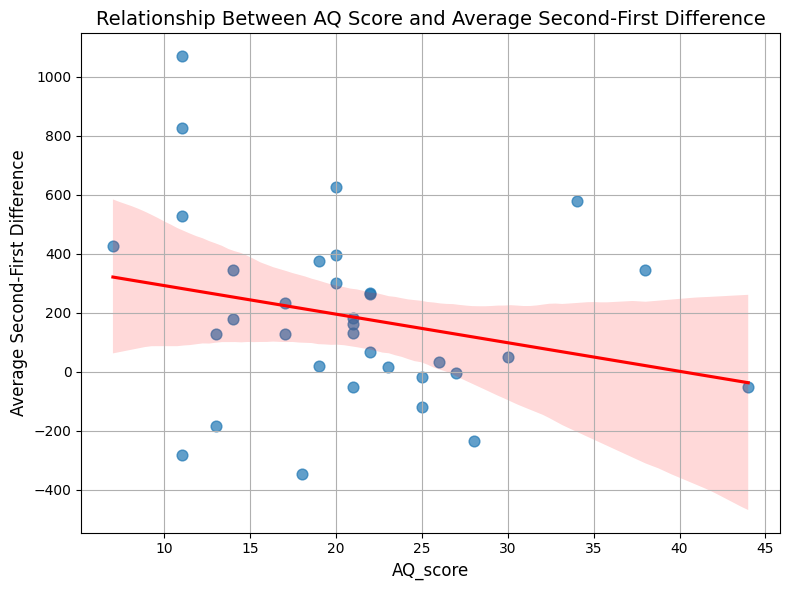

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pulisci i dati
df_clean = df.dropna(subset=["AQ_score", "average_second_first_difference"])

# Crea il grafico
plt.figure(figsize=(8, 6))
sns.regplot(
    x="AQ_score",
    y="average_second_first_difference",
    data=df_clean,
    ci=95,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Aggiungi titoli e labels
plt.title("Relationship Between AQ Score and Average Second-First Difference", fontsize=14)
plt.xlabel("AQ_score", fontsize=12)
plt.ylabel("Average Second-First Difference", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


it the same as doing... the correlation between AQ and the sum beteen the differences per subject

In [58]:
# from scipy.stats import pearsonr
# df_clean = df.dropna(subset=["AQ_score", "sum_second_first_difference"])
# correlation, p_value = pearsonr(df_clean["AQ_score"], df_clean["sum_second_first_difference"])

# print(f"Correlazione di Pearson: {correlation}")
# print(f"p-value: {p_value}")

# if p_value < 0.05:
#     print("La correlazione è statisticamente significativa.")
# else:
#     print("La correlazione NON è statisticamente significativa.")

- CORRELAZIONE TRA **AQ LEVEL E DIFFERENZE, MEDIATE PER SOGGETTO, TRA SECONDA E PRIMA METà**

In [59]:
from scipy.stats import spearmanr

rho, p_value = spearmanr(df_clean["AQ_level"], df_clean["average_second_first_difference"])

print(f"Spearman rho: {rho}")
print(f"p-value: {p_value}")


if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Spearman rho: -0.34697033249886644
p-value: 0.044385102542621784
La correlazione è statisticamente significativa.


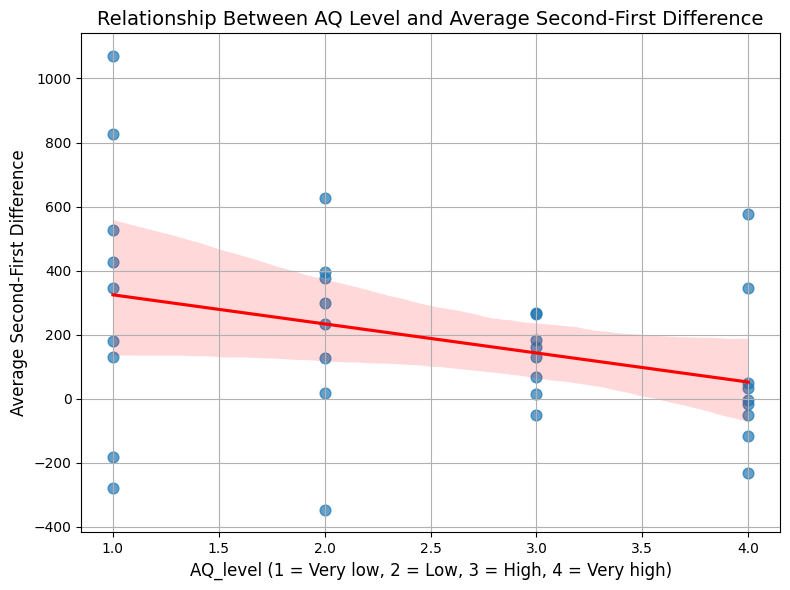

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot con linea di regressione
plt.figure(figsize=(8, 6))
sns.regplot(
    x="AQ_level", 
    y="average_second_first_difference", 
    data=df_clean, 
    ci=95, 
    scatter_kws={"s": 60, "alpha": 0.7}, 
    line_kws={"color": "red"}
)

plt.title("Relationship Between AQ Level and Average Second-First Difference", fontsize=14)
plt.xlabel("AQ_level (1 = Very low, 2 = Low, 3 = High, 4 = Very high)", fontsize=12)
plt.ylabel("Average Second-First Difference", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


<span style="color:red">DA QUI IN POI FACCIO CORRELAZIONI CON STAI_S</span>
STAI scores are commonly classified as “no or low anxiety” (20-37), “moderate anxiety” (38-44), and “high anxiety” (45-80).


In [61]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["STAI_S", "totale_right_choices"])
correlation, p_value = spearmanr(df_clean["STAI_S"], df_clean["totale_right_choices"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: 0.03978579176108817
p-value: 0.823224251588333
La correlazione NON è statisticamente significativa.


In [62]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["STAI_S", "totale_percent_choices_over_10_actions"])
correlation, p_value = spearmanr(df_clean["STAI_S"], df_clean["totale_percent_choices_over_10_actions"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: -0.015604694598308981
p-value: 0.9302009677452612
La correlazione NON è statisticamente significativa.


In [63]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["STAI_S", "TotalPoints"])
correlation, p_value = spearmanr(df_clean["STAI_S"], df_clean["TotalPoints"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: 0.031209389196617962
p-value: 0.8609098496030471
La correlazione NON è statisticamente significativa.


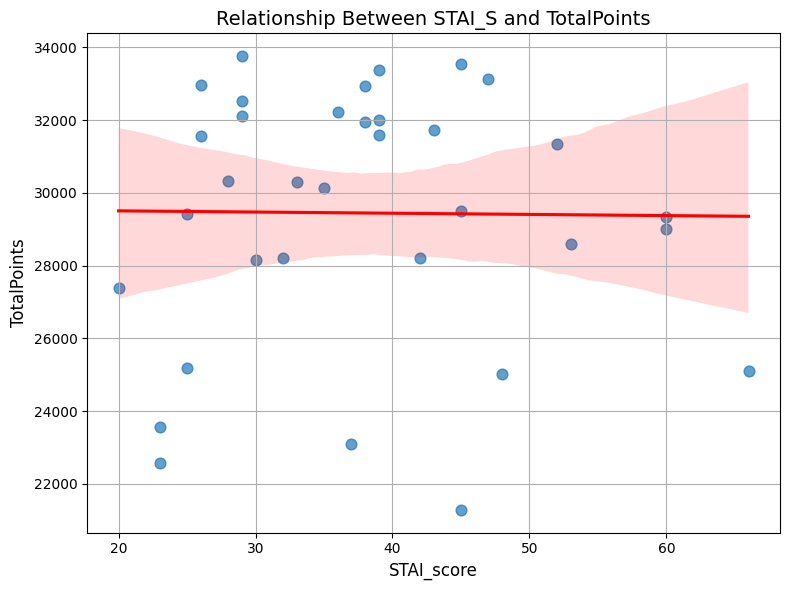

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pulisci i dati
df_clean = df.dropna(subset=["STAI_S", "TotalPoints"])

# Crea il grafico scatter con linea di regressione
plt.figure(figsize=(8, 6))
sns.regplot(
    x="STAI_S",
    y="TotalPoints",
    data=df_clean,
    ci=95,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Aggiungi titoli e label
plt.title("Relationship Between STAI_S and TotalPoints", fontsize=14)
plt.xlabel("STAI_score", fontsize=12)
plt.ylabel("TotalPoints", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
from scipy.stats import spearmanr

df_clean = df.dropna(subset=["STAI_S", "average_second_first_difference"])

correlation, p_value = spearmanr(df_clean["STAI_S"], df_clean["average_second_first_difference"])

print(f"Correlazione di Spearman: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di Spearman: -0.2317756109454717
p-value: 0.18718038843750684
La correlazione NON è statisticamente significativa.


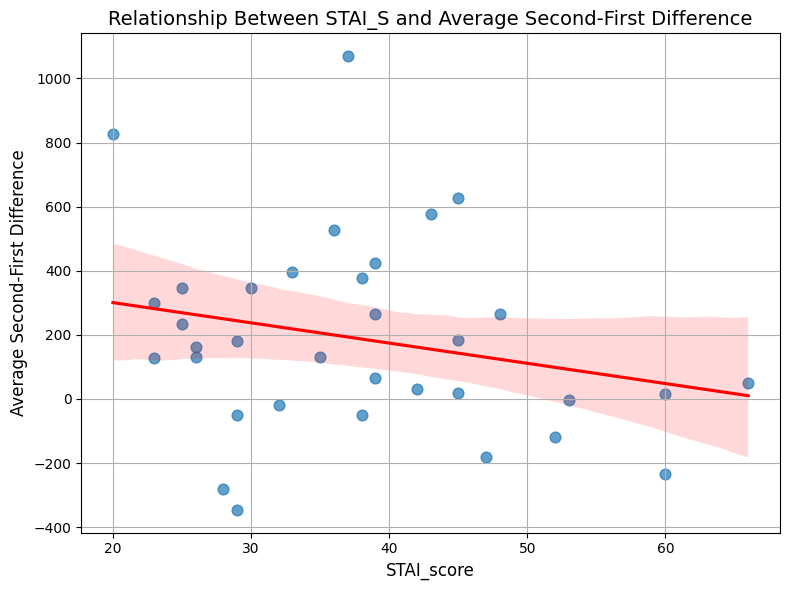

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pulisci i dati
df_clean = df.dropna(subset=["STAI_S", "average_second_first_difference"])

# Crea il grafico
plt.figure(figsize=(8, 6))
sns.regplot(
    x="STAI_S",
    y="average_second_first_difference",
    data=df_clean,
    ci=95,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Aggiungi titoli e labels
plt.title("Relationship Between STAI_S and Average Second-First Difference", fontsize=14)
plt.xlabel("STAI_score", fontsize=12)
plt.ylabel("Average Second-First Difference", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color:red">DA QUI IN POI FACCIO CORRELAZIONI CON STAI_T</span>
(STAI scores are commonly classified as “no or low anxiety” (20-37), “moderate anxiety” (38-44), and “high anxiety” (45-80).)

In [68]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["STAI_T", "totale_right_choices"])
correlation, p_value = spearmanr(df_clean["STAI_T"], df_clean["totale_right_choices"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: 0.24975148441940226
p-value: 0.15429989379098027
La correlazione NON è statisticamente significativa.


In [69]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["STAI_T", "totale_percent_choices_over_10_actions"])
correlation, p_value = spearmanr(df_clean["STAI_T"], df_clean["totale_percent_choices_over_10_actions"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: 0.2101561314657697
p-value: 0.23288757895343298
La correlazione NON è statisticamente significativa.


In [70]:
from scipy.stats import spearmanr
df_clean = df.dropna(subset=["STAI_T", "TotalPoints"])
correlation, p_value = spearmanr(df_clean["STAI_T"], df_clean["TotalPoints"])

print(f"Correlazione di spearmanr: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di spearmanr: 0.18920169914349133
p-value: 0.28386503512549666
La correlazione NON è statisticamente significativa.


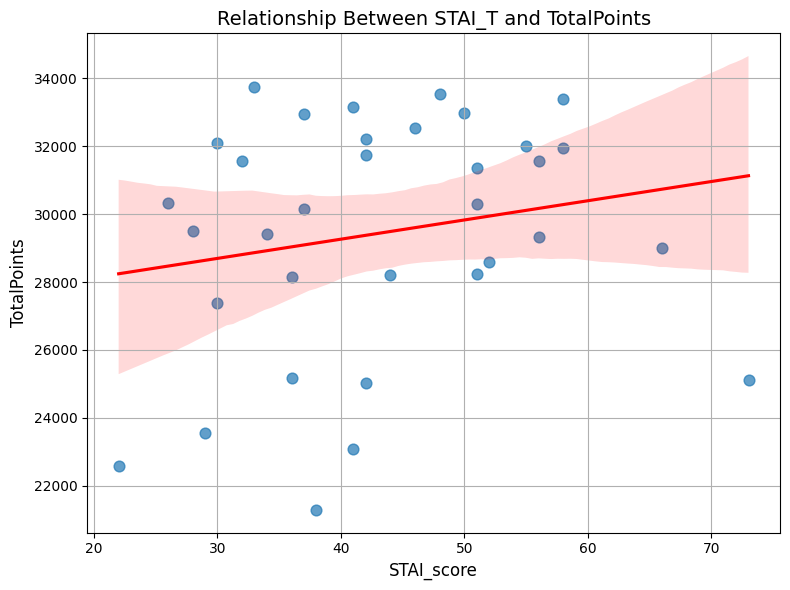

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pulisci i dati
df_clean = df.dropna(subset=["STAI_T", "TotalPoints"])

# Crea il grafico scatter con linea di regressione
plt.figure(figsize=(8, 6))
sns.regplot(
    x="STAI_T",
    y="TotalPoints",
    data=df_clean,
    ci=95,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Aggiungi titoli e label
plt.title("Relationship Between STAI_T and TotalPoints", fontsize=14)
plt.xlabel("STAI_score", fontsize=12)
plt.ylabel("TotalPoints", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
from scipy.stats import spearmanr

df_clean = df.dropna(subset=["STAI_T", "average_second_first_difference"])

correlation, p_value = spearmanr(df_clean["STAI_T"], df_clean["average_second_first_difference"])

print(f"Correlazione di Spearman: {correlation}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print("La correlazione è statisticamente significativa.")
else:
    print("La correlazione NON è statisticamente significativa.")

Correlazione di Spearman: -0.25879488678317486
p-value: 0.13943788942311638
La correlazione NON è statisticamente significativa.


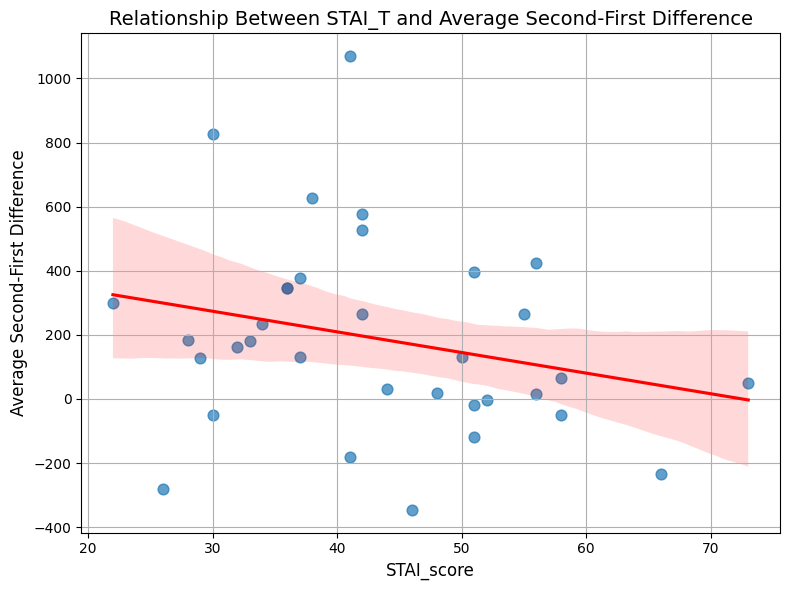

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pulisci i dati
df_clean = df.dropna(subset=["STAI_T", "average_second_first_difference"])

# Crea il grafico
plt.figure(figsize=(8, 6))
sns.regplot(
    x="STAI_T",
    y="average_second_first_difference",
    data=df_clean,
    ci=95,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Aggiungi titoli e labels
plt.title("Relationship Between STAI_T and Average Second-First Difference", fontsize=14)
plt.xlabel("STAI_score", fontsize=12)
plt.ylabel("Average Second-First Difference", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

<span style="color:red">DA QUI IN POI FACCIO CORRELAZIONI CON GAMER IDENTITY SCALE</span>


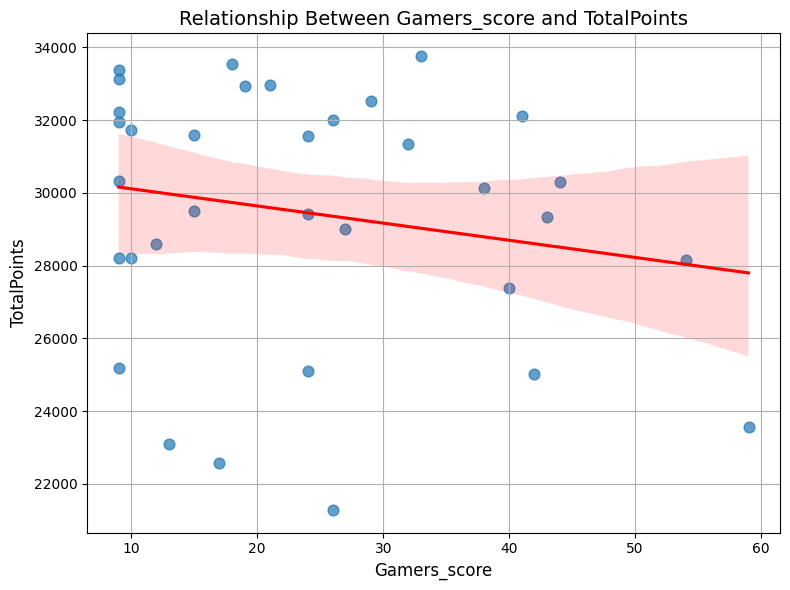

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pulisci i dati
df_clean = df.dropna(subset=["Gamers_score", "TotalPoints"])

# Crea il grafico scatter con linea di regressione
plt.figure(figsize=(8, 6))
sns.regplot(
    x="Gamers_score",
    y="TotalPoints",
    data=df_clean,
    ci=95,
    scatter_kws={"s": 60, "alpha": 0.7},
    line_kws={"color": "red"}
)

# Aggiungi titoli e label
plt.title("Relationship Between Gamers_score and TotalPoints", fontsize=14)
plt.xlabel("Gamers_score", fontsize=12)
plt.ylabel("TotalPoints", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()